### Import Titanic dataset

In [1]:
import joblib

data = joblib.load( 'preprocessed_data\\Titanic.pkl')

### Create train test, check ratio of y values

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data["X_encoded_scaled"], data["y"], test_size=0.33, random_state=42)
print(y_train.value_counts())


Survived
0.0    288
1.0    189
Name: count, dtype: int64


### Optimization with Optuna, StratifiedKFold and F1score is used because imbalanced input classes.

In [11]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import os
import sys
from contextlib import contextmanager

# Suppress stdout and stderr
@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull."""
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def objective(trial, params_dict):
    with suppress_stdout_stderr():
        # Define parameters for CatBoost
        param = {
            'learning_rate': trial.suggest_categorical('learning_rate', params_dict['learning_rate']),
            'iterations': trial.suggest_categorical('iterations', params_dict['iterations']),
            'depth': trial.suggest_categorical('depth', params_dict['depth']),
            'min_child_samples': trial.suggest_categorical('min_data_in_leaf', params_dict['min_data_in_leaf']),
            'subsample': trial.suggest_categorical('subsample', params_dict['subsample']),
            'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', params_dict['colsample_bylevel']),
            'l2_leaf_reg': trial.suggest_categorical('l2_leaf_reg', params_dict['l2_leaf_reg']),
            'random_state': 0,
            'verbose': 0,
        }

        # Initialize CatBoostClassifier
        model = CatBoostClassifier(**param)

        # Perform cross-validation
        scores = cross_val_score(model, X_train, y_train.ravel(), cv=kf, scoring='f1')

        # Return mean accuracy
        return scores.mean()

# Define parameter grid for CatBoost
params_dict = {
    'learning_rate': [0.6, 0.1, 0.8],
    'iterations': [10, 10, 50],
    'depth': [6, 1, 8],
    'min_data_in_leaf': [0],
    'subsample': [0.6, 0.1, 0.8],
    'colsample_bylevel': [1.0],
    'l2_leaf_reg': [8, 1, 10],
}

# Create a StratifiedKFold for cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Initialize and optimize the study
study = optuna.create_study(direction='maximize')  # Default sampler is sufficient for single-objective
study.optimize(lambda trial: objective(trial, params_dict), n_trials=30)

# Retrieve best parameters and score
best_params = study.best_params
best_score = study.best_value  

print(f"Best parameters: {best_params}")
print(f"Best f1score score on train: {best_score * 100:.2f}%")

# Check on test data
CatB = CatBoostClassifier(**best_params, random_state=0, verbose=0) 
CatB.fit(X_train, y_train)
y_pred_test = CatB.predict(X_test)
print(f"Best f1score score on test: {f1_score(y_test, y_pred_test) * 100:.2f}%")


[I 2024-11-17 21:39:27,502] A new study created in memory with name: no-name-b9f68f06-40c2-44ec-a737-5840318e5acb
[I 2024-11-17 21:39:27,765] Trial 0 finished with value: 0.7705392416660022 and parameters: {'learning_rate': 0.8, 'iterations': 10, 'depth': 6, 'min_data_in_leaf': 0, 'subsample': 0.8, 'colsample_bylevel': 1.0, 'l2_leaf_reg': 10}. Best is trial 0 with value: 0.7705392416660022.
[I 2024-11-17 21:39:27,936] Trial 1 finished with value: 0.707315725468293 and parameters: {'learning_rate': 0.6, 'iterations': 10, 'depth': 1, 'min_data_in_leaf': 0, 'subsample': 0.6, 'colsample_bylevel': 1.0, 'l2_leaf_reg': 1}. Best is trial 0 with value: 0.7705392416660022.
[I 2024-11-17 21:39:28,236] Trial 2 finished with value: 0.7421174733696415 and parameters: {'learning_rate': 0.1, 'iterations': 10, 'depth': 8, 'min_data_in_leaf': 0, 'subsample': 0.8, 'colsample_bylevel': 1.0, 'l2_leaf_reg': 10}. Best is trial 0 with value: 0.7705392416660022.
[I 2024-11-17 21:39:28,457] Trial 3 finished wit

Best parameters: {'learning_rate': 0.8, 'iterations': 10, 'depth': 6, 'min_data_in_leaf': 0, 'subsample': 0.8, 'colsample_bylevel': 1.0, 'l2_leaf_reg': 10}
Best f1score score on train: 77.05%
Best f1score score on test: 76.04%


## Parameter Optimization Results

### First Optimization (20 Iterations)
**Parameter Grid:**
```python
params_dict = {
    'learning_rate': [0.01, 0.05, 1.0],
    'iterations': [100, 100, 500],
    'depth': [1, 5, 10],
    'min_data_in_leaf': [0, 5, 1],
    'subsample': [0.1, 0.5, 1.0],
    'colsample_bylevel': [0.1, 0.5, 1.0],
    'l2_leaf_reg': [0, 5, 10],
}

Best parameters: {'learning_rate': 1.0, 'iterations': 100, 'depth': 10, 'min_data_in_leaf': 0, 'subsample': 1.0, 'colsample_bylevel': 1.0, 'l2_leaf_reg': 5}
Best f1score score on train: 76.14%
Best f1score score on test: 73.10%
```

### Second Optimization (100 Iterations)
**Parameter Grid:**
```python
params_dict = {
    'learning_rate': [0.8, 0.1, 1.0],
    'iterations': [50, 50, 150],
    'depth': [8, 1, 10],
    'min_data_in_leaf': [0, 1, 3],
    'subsample': [0.8, 0.1, 1.0],
    'colsample_bylevel': [0.8, 0.1, 1.0],
    'l2_leaf_reg': [3, 1, 8],
}

Best parameters: {'learning_rate': 0.8, 'iterations': 50, 'depth': 8, 'min_data_in_leaf': 0, 'subsample': 0.8, 'colsample_bylevel': 1.0, 'l2_leaf_reg': 8}
Best f1score score on train: 77.25%
Best f1score score on test: 75.53%
```

### Third Optimization (30 Iterations)
**Parameter Grid:**
```python
params_dict = {
    'learning_rate': [0.6, 0.1, 0.8],
    'iterations': [10, 10, 50],
    'depth': [6, 1, 8],
    'min_data_in_leaf': [0],
    'subsample': [0.6, 0.1, 0.8],
    'colsample_bylevel': [1.0],
    'l2_leaf_reg': [8, 1, 10],
}
Best parameters: {'learning_rate': 0.8, 'iterations': 10, 'depth': 6, 'min_data_in_leaf': 0, 'subsample': 0.8, 'colsample_bylevel': 1.0, 'l2_leaf_reg': 10}
Best f1score score on train: 77.05%
Best f1score score on test: 76.04%
```

---
### Create Confusion matrix

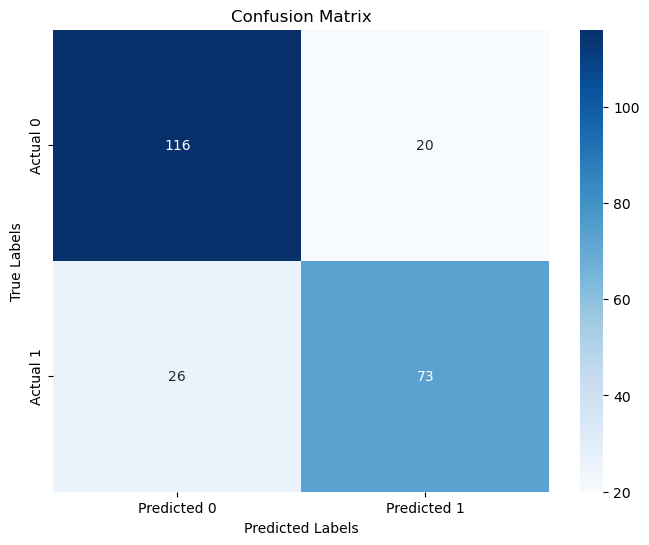

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Check on test data
params = {'learning_rate': 0.8, 'iterations': 10, 'depth': 6, 'min_data_in_leaf': 0, 'subsample': 0.8, 'colsample_bylevel': 1.0, 'l2_leaf_reg': 10}
CatB = CatBoostClassifier(**params, random_state=0, verbose=0)  
CatB.fit(X_train, y_train)
y_pred_test = CatB.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_test)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### 0 = will not survive
### 1 = will survive
### It is predicted to survive 20 times, but it does not.
### It is predicted not to survive 26 times, but it does.

---
## Roc curve

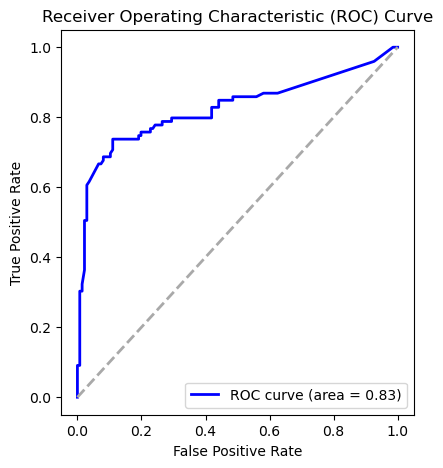

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_test_probs = CatB.predict_proba(X_test)[:, 1]

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_test_probs)
roc_auc = roc_auc_score(y_test, y_test_probs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

---
## Precision Recall Curve

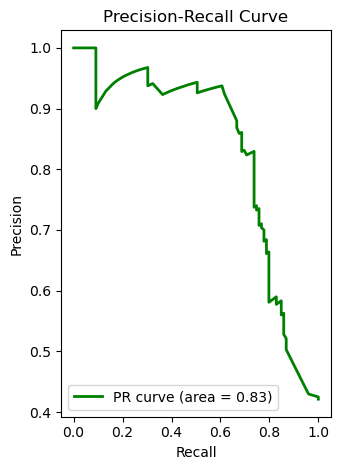

In [14]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, _ = precision_recall_curve(y_test, y_test_probs)
pr_auc = auc(recall, precision)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

---
## make a version where we wannt to predict, all people who survive, even we predict some who will not.

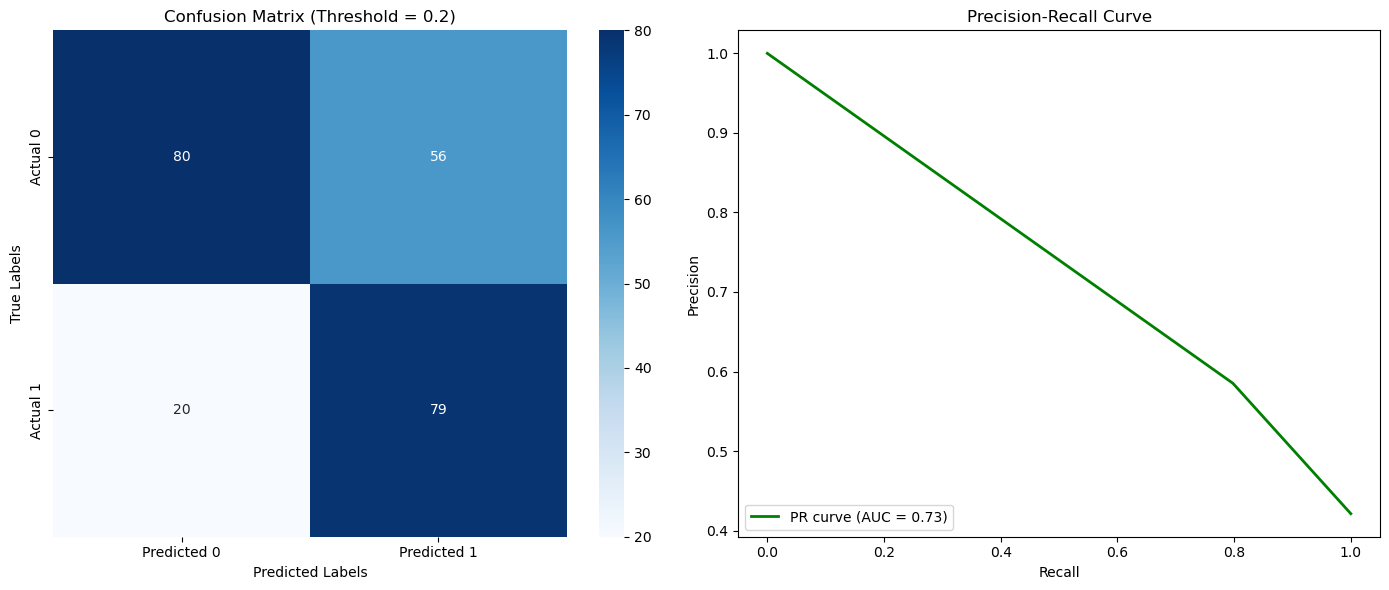

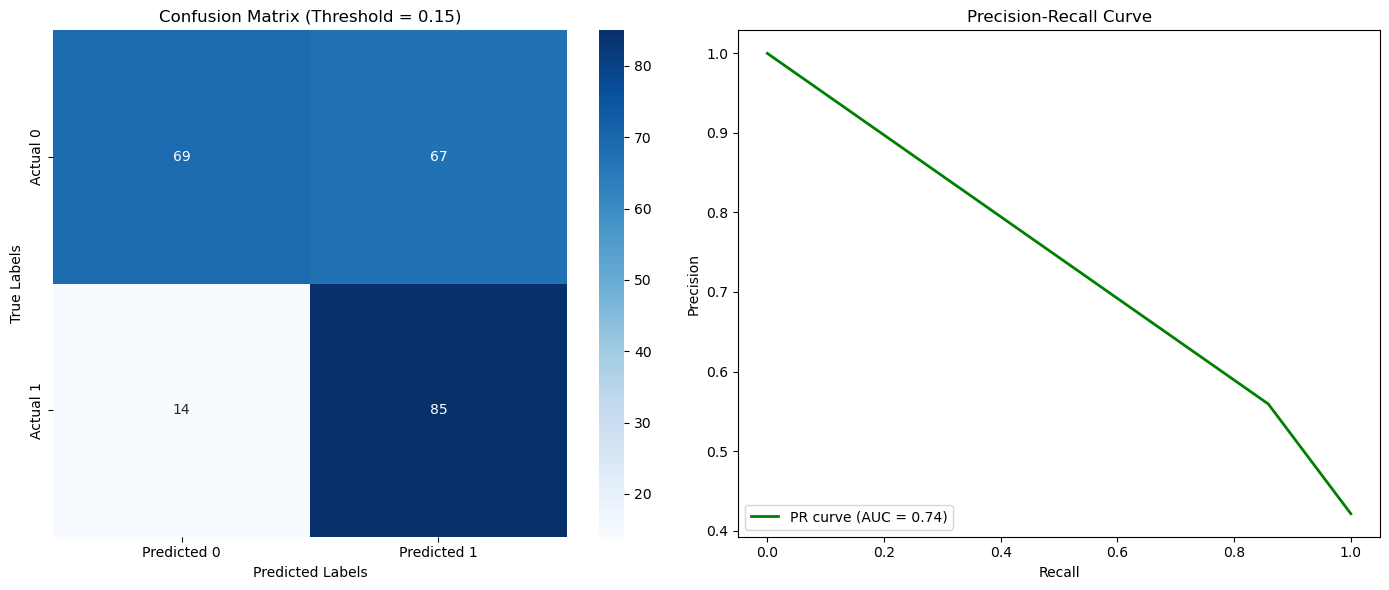

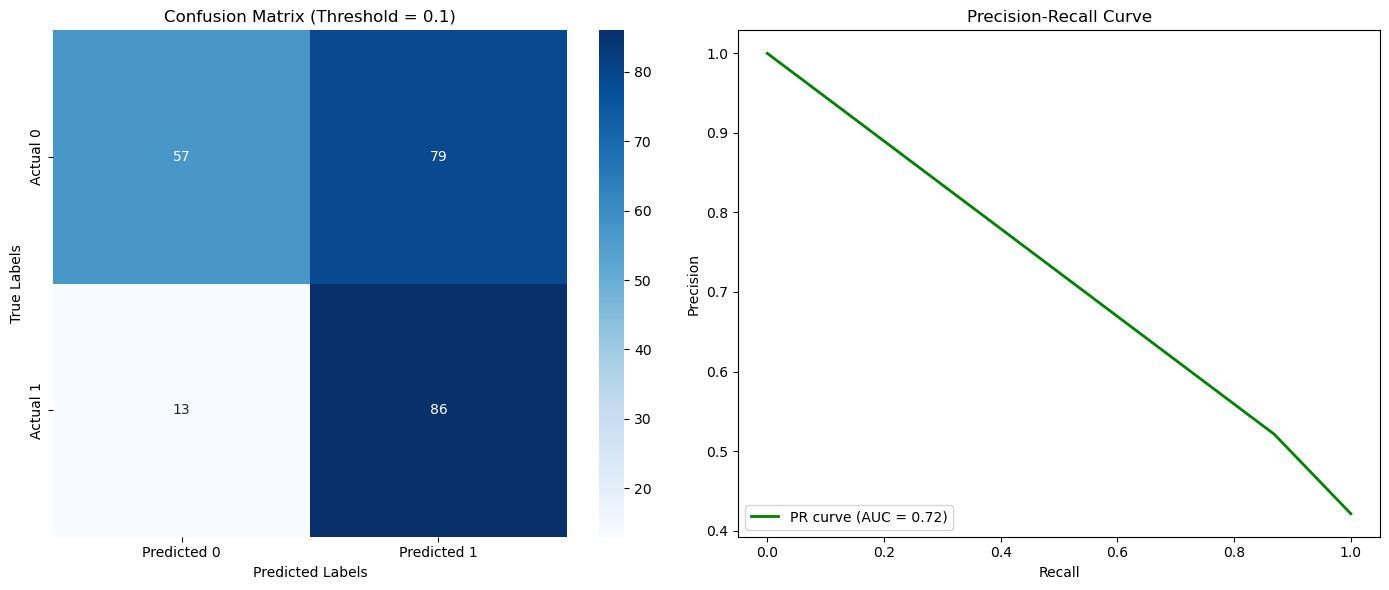

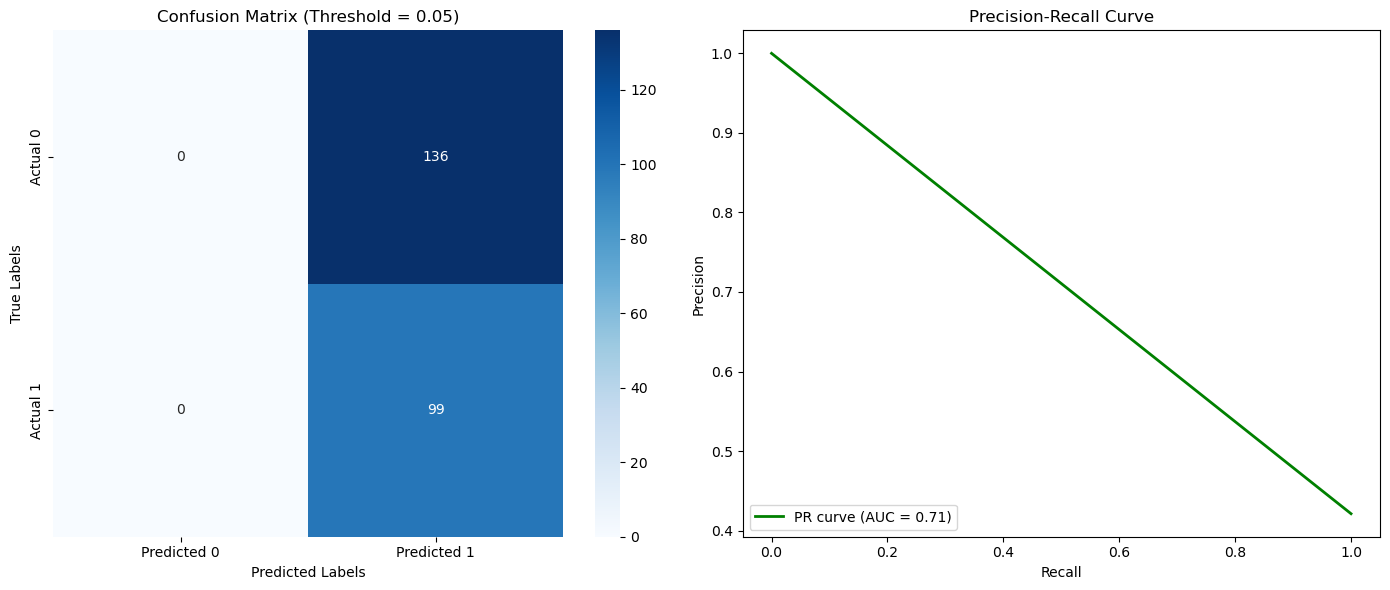

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc
from catboost import CatBoostClassifier

# Check on test data
params = {'learning_rate': 0.8, 'iterations': 10, 'depth': 6, 'min_data_in_leaf': 0, 
          'subsample': 0.8, 'colsample_bylevel': 1.0, 'l2_leaf_reg': 10}
CatB = CatBoostClassifier(**params, random_state=0, verbose=0)  
CatB.fit(X_train, y_train)

# Get predicted probabilities (probability for the positive class)
y_pred_prob = CatB.predict_proba(X_test)[:, 1]

# Thresholds to evaluate
thresholds = [0.20, 0.15, 0.10, 0.05]

# Loop through each threshold
for threshold in thresholds:
    # Compute predicted labels based on threshold
    y_pred_test = (y_pred_prob >= threshold).astype(int)
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    
    # Compute Precision-Recall Curve and AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_test)
    pr_auc = auc(recall, precision)
    
    # Plot both confusion matrix and precision-recall curve
    plt.figure(figsize=(14, 6))
    
    # Confusion Matrix Plot
    plt.subplot(1, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'], 
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix (Threshold = {threshold})')
    
    # Precision-Recall Curve Plot
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    
    plt.tight_layout()
    plt.show()


## under 0.05, all predictions made 1 as result.
## 0.1 is a hugh difference, we loose 13% from the True positive as false positive, but for this we turm 41% of the false negative to true negative.
## 0.15 is not a big difference
## 0.2 is more balanced. 20% from the True positive as false positive, but for this we turm 59% of the false negative to true negative.